# 다중선형회귀

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler

## #02. 데이터셋 준비하기

In [2]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


## #03. 데이터 전처리

### 결측치 확인

In [3]:
origin.isna().sum()

길이    0
높이    0
두께    0
무게    0
dtype: int64

## #04. 탐색적 데이터 분석

### 기본통계 확인

In [4]:
origin.describe()

,길이,높이,두께,무게
count,56.000000,56.000000,56.000000,56.000000
mean,27.892857,7.862143,4.745536,382.239286
std,9.021668,2.878343,1.775006,347.617717
min,8.400000,2.110000,1.410000,5.900000
25%,21.825000,5.690000,3.520000,120.000000
50%,25.300000,6.920000,4.155000,207.500000
75%,36.625000,10.850000,6.450000,692.500000
max,44.000000,12.800000,8.140000,1100.000000


> 평균값의 차이가 크기 때문에 표준화가 필요해 보인다.

상자그림

In [5]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

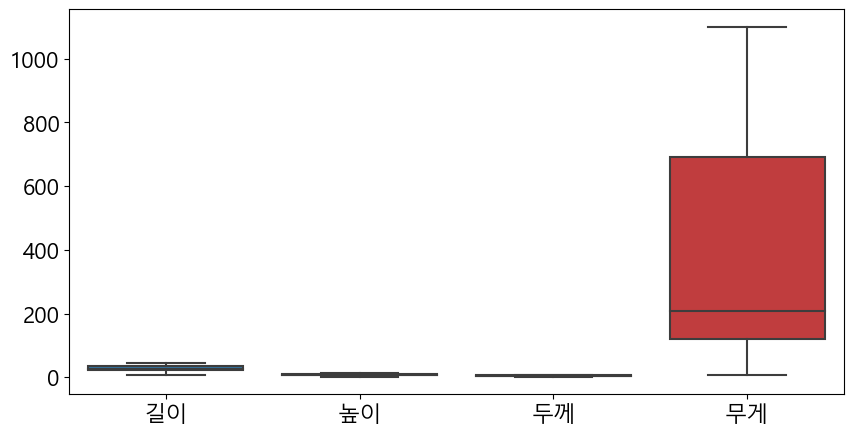

In [6]:
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin)
plt.show()
plt.close()

### 산점도 그래프와 추세선 확인

d:\python\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

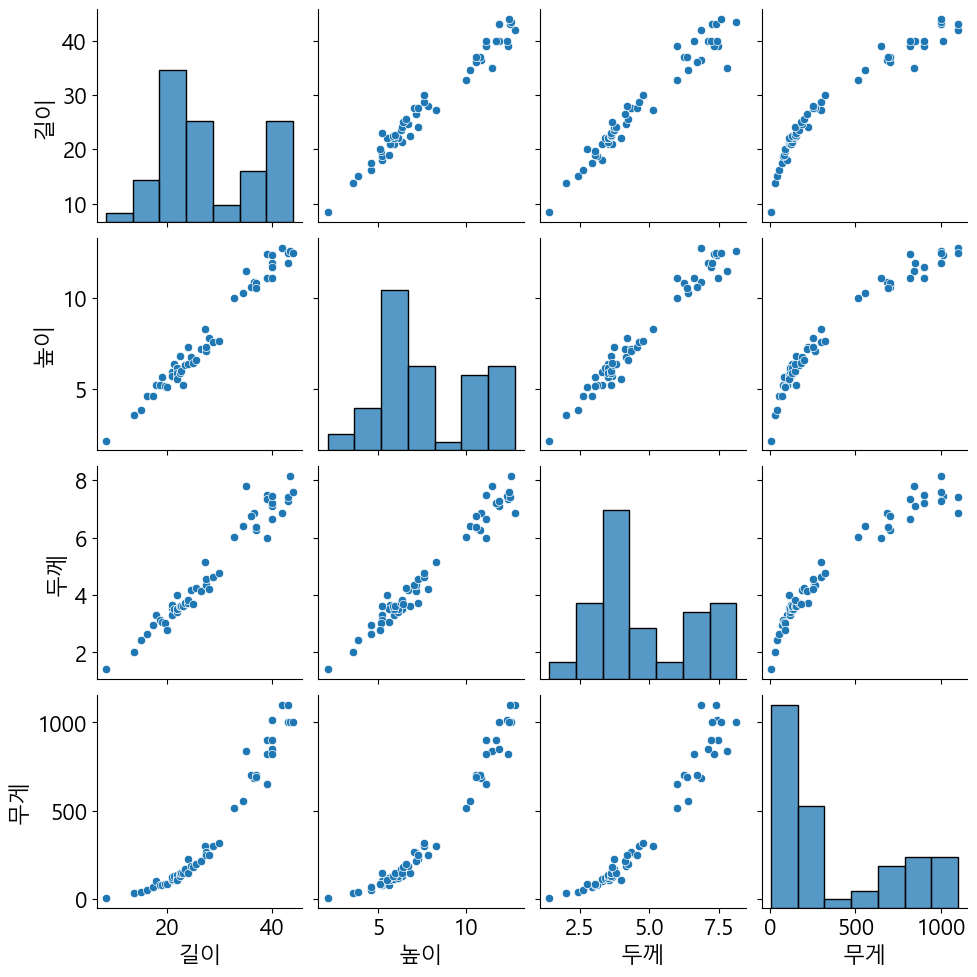

In [7]:
plt.figure(figsize=(30, 30))
sb.pairplot(origin)
plt.show()
plt.close()

> 다중 공선성이 발생할 것으로 보이고, 선형회귀보다는 다항회귀가 더 적합해 보이지만 예제를 위해 다중선형회귀로 진행

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [8]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [9]:
x = origin[['길이', '높이', '두께']]
y = origin[['무게']]
x.shape, y.shape

((56, 3), (56, 1))

### 데이터 표준화

In [10]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)

y_scaller = StandardScaler()
y_scale = y_scaller.fit_transform(y)

x_scale.shape, y_scale.shape

((56, 3), (56, 1))

표준화 전후 상자그림 비교

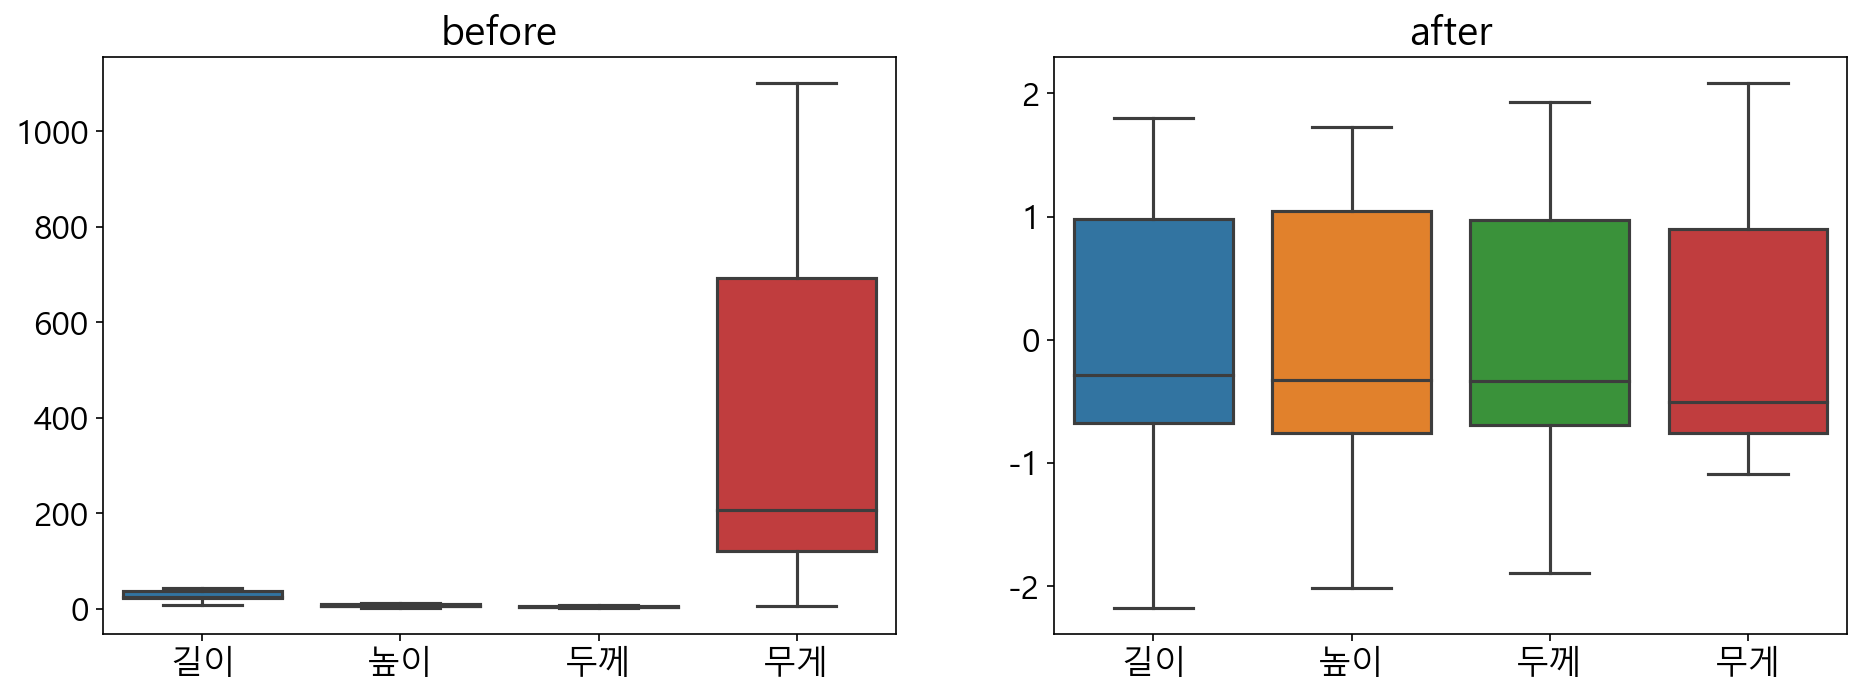

In [11]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns = ['길이', '높이', '두께'])
y_scale_df = DataFrame(y_scale, columns = ['무게'])
tmp = merge(x_scale_df, y_scale_df, left_index = True, right_index = True)

fig, ax = plt.subplots(1, 2, figsize = (15, 5), dpi = 150)

sb.boxplot(data = origin, ax = ax[0])
sb.boxplot(data = tmp, ax = ax[1])
ax[0].set_title('before')
ax[1].set_title('after')

plt.show()
plt.close()

### 훈련 데이터와 검증 데이터로 분할

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size = 0.3, random_state = 777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 3), (17, 3), (39, 1), (17, 1))

## #06. 모델 개발

### 모델 정의

In [13]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [17]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
2/2 [==============================] - 1s 142ms/step - loss: 1.0437 - mae: 0.9376 - val_loss: 0.7140 - val_mae: 0.7788 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 24ms/step - loss: 0.8955 - mae: 0.8681 - val_loss: 0.6110 - val_mae: 0.7211 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 0.7774 - mae: 0.8062 - val_loss: 0.5222 - val_mae: 0.6677 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 31ms/step - loss: 0.6694 - mae: 0.7475 - val_loss: 0.4477 - val_mae: 0.6192 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 28ms/step - loss: 0.5747 - mae: 0.6925 - val_loss: 0.3846 - val_mae: 0.5744 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 25ms/step - loss: 0.4918 - mae: 0.6402 - val_loss: 0.3281 - val_mae: 0.5305 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 25ms/step - loss: 0.4256 - mae: 0.5931 - val_loss: 0.2781 - val_mae: 0.4879 - lr: 0.001

## #07. 학습 결과 평가

In [18]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs', inplace = True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,1.043707,0.937582,0.713951,0.778840,0.001
2,0.895519,0.868110,0.611036,0.721134,0.001
3,0.777400,0.806239,0.522220,0.667689,0.001
4,0.669395,0.747450,0.447685,0.619214,0.001
5,0.574726,0.692455,0.384650,0.574441,0.001
6,0.491808,0.640235,0.328134,0.530464,0.001
7,0.425554,0.593060,0.278128,0.487853,0.001
8,0.361365,0.546169,0.233876,0.446208,0.001
9,0.306057,0.504508,0.194188,0.404593,0.001


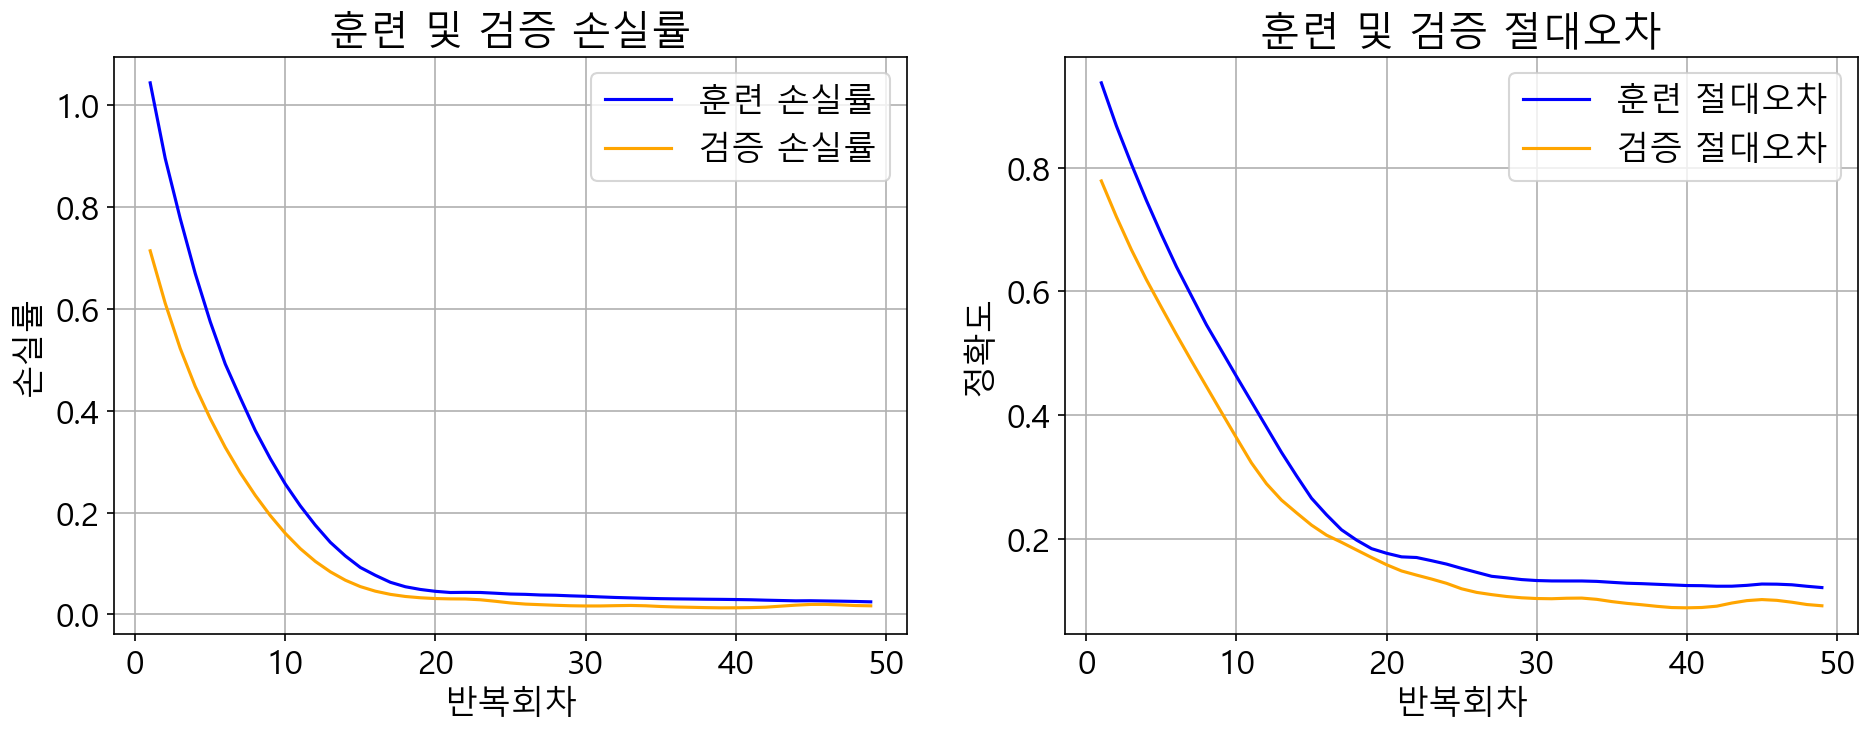

In [19]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [20]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 2ms/step - loss: 0.0245 - mae: 0.1198
최종 훈련 손실률: 0.024457, 최종 훈련 절대오차: 0.119820
1/1 [==============================] - 0s 19ms/step - loss: 0.0170 - mae: 0.0914
최종 검증 손실률: 0.017029, 최종 검증 절대오차: 0.091429


## #08. 학습 결과 적용

### 예측 결과 산정

In [21]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 16ms/step


### 결과 데이터 셋 구성

In [22]:
train_df = DataFrame(x_train, columns=['길이','높이','두께'])
train_df['무게(관측치)'] = y_train.flatten()
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)']-train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.927534,-0.954292,-0.969558,-0.862814,-0.819813,-0.043001
1,-2.180225,-2.016507,-1.896175,-1.092422,-1.423624,0.331202
2,-0.659101,-0.779008,-0.696689,-0.761217,-0.678564,-0.082653
3,-0.368297,-0.396891,-0.327179,-0.563830,-0.487874,-0.075956
4,1.577847,1.731046,1.207709,2.083485,1.660054,0.423431


In [23]:
test_df = DataFrame(x_test, columns=['길이','높이','두께'])
test_df['무게(관측치)'] = y_test.flatten()
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)']-test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.659101,-0.614242,-0.696689,-0.732189,-0.653915,-0.078274
1,-0.770948,-0.761480,-0.611417,-0.746703,-0.684742,-0.061961
2,-0.580807,-0.670333,-0.634156,-0.688648,-0.633736,-0.054912
3,-0.043940,-0.204080,-0.099788,-0.383859,-0.335650,-0.048208
4,0.235678,-0.084887,0.013907,-0.180666,-0.120356,-0.060310


### 실제 결과값과 머신러닝에 의한 예측값 비교

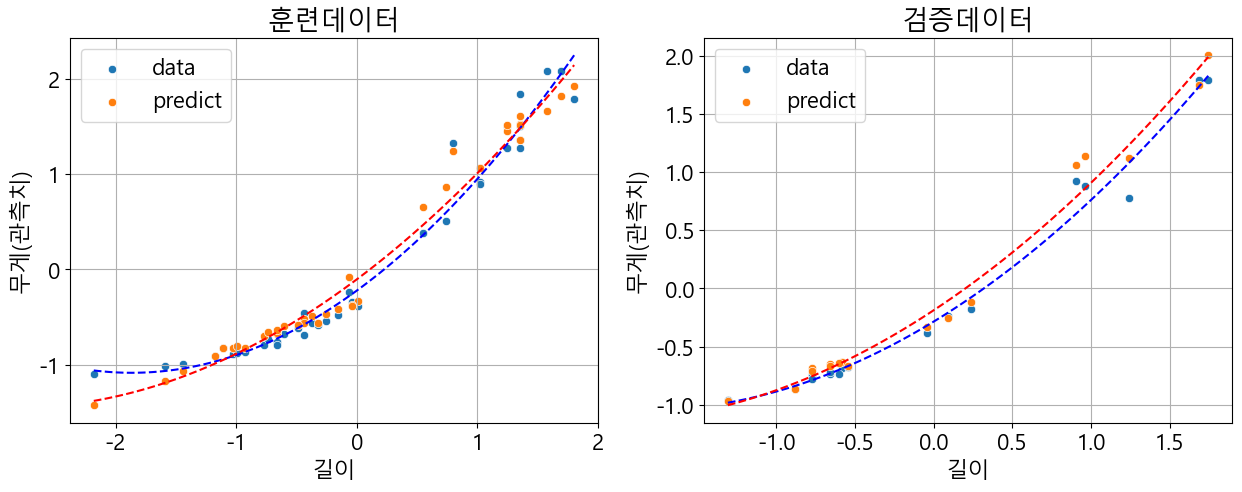

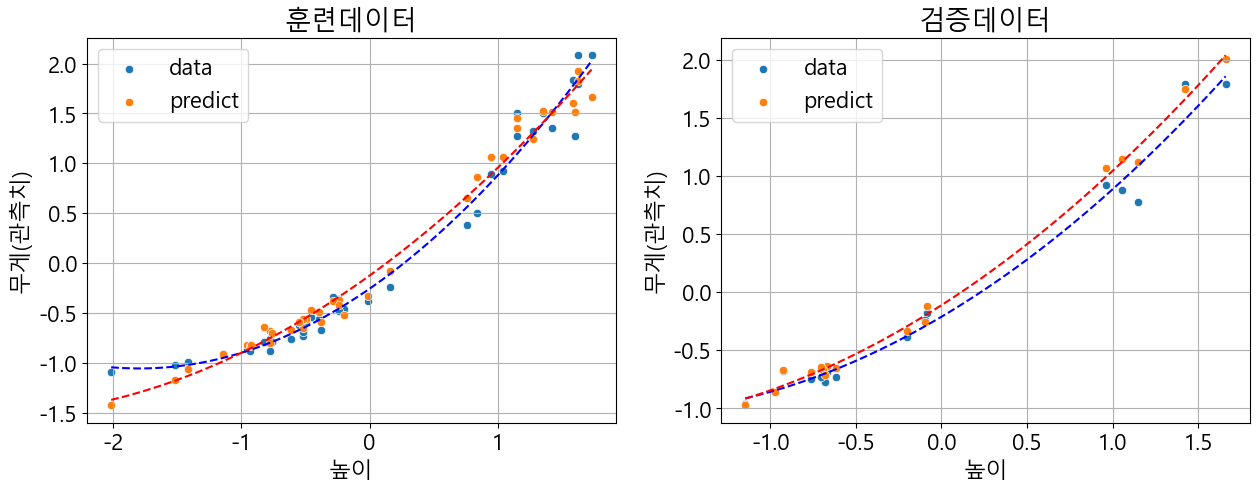

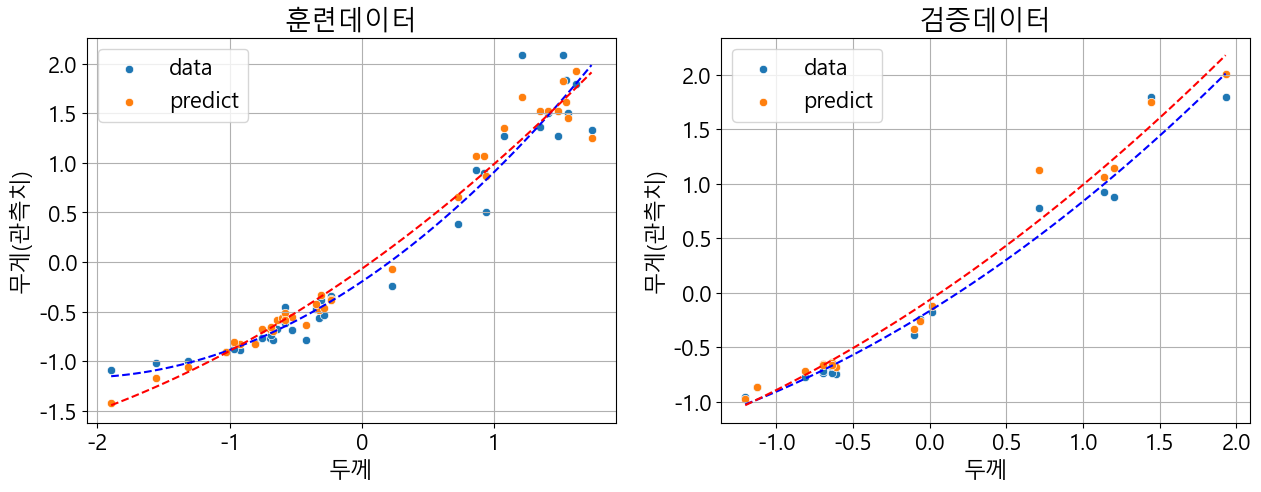

In [24]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))